# Variational Autoencoders

<p align="center">
  <img src="https://lilianweng.github.io/lil-log/assets/images/vae-gaussian.png" width=80%/>
</p>


Image reference: [https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#beta-vae](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#beta-vae)  

In [130]:
import numpy as np
import torch
import torch.utils
import torch.utils.data
import torch.nn as nn
import torchvision

### Hyperparameters and other configuration variables

In [131]:
params = {
  'data_size': 784,
  'latent_size': 20,
  'hidden_size': 400,
  'lr': 0.001,
  'batch_size': 256,
  'epochs': 50,
  # 'device': "cuda:0",  # uncomment this if using the GPU and comment the next line
  'device': 'cpu',
  'seed': 1234321,
  'log_after': 5,  # log after every this number of epochs
  'TSNE_num_samples': 1000
}

### Creating the VAE model

<p align="center">
  <img src="https://theaisummer.com/static/25f603171034d2fc8f6a518b8537f85a/ee604/vae.png" width=60%/>
</p>

Image reference: [https://theaisummer.com/Autoencoder/](https://theaisummer.com/Autoencoder/)  

In [132]:
# Model structure borrowed from: https://github.com/Atcold/pytorch-Deep-Learning 
class VAE(nn.Module):
  def __init__(self, input_size, hidden_size, latent_size):
    super().__init__()

    self.latent_size = latent_size
    self.input_size = input_size
    self.hidden_size = hidden_size
    
    self.encoder = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, latent_size*2)  # *2 because will output both mean and log variances of latent distribution
    )

    self.decoder = nn.Sequential(
        nn.Linear(latent_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, input_size),
        nn.Sigmoid()  # to make sure pixel values are between (0, 1)
    )

  def reparameterise(self, mu, logvar):
    if self.training:
      std = torch.exp(0.5*logvar)   # 0.5 as to convert log(variance) into log(std)
      eps = torch.randn_like(mu)
      return eps.mul(std).add_(mu)
    else:
      return mu

  def forward(self, x):
    mu_logvar = self.encoder(x.view(-1, self.input_size)).view(-1, 2, self.latent_size)
    mu = mu_logvar[:, 0, :]
    logvar = mu_logvar[:, 1, :]
    z = self.reparameterise(mu, logvar)
    return self.decoder(z), mu, logvar  # mu, logvar are needed for calculating KL divergence with prior

### Loss function
<p>
  <img src="https://miro.medium.com/max/1564/1*UvKwG5skByZda38WVhMx7A.png" width=50%/>
</p>

In [133]:
def VAE_loss(decoded_data_points, orig_data_points, mu, logvar, beta=1.0):
  BCE = torch.nn.functional.binary_cross_entropy(decoded_data_points, orig_data_points, reduction='sum')
  KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))    # https://stats.stackexchange.com/a/7449/245269

  return BCE + beta * KLD

### Instantiate objects for training

In [145]:
device = torch.device(params['device'])

# Instantiating all random modules with the seed
torch.manual_seed(params['seed'])
np.random.seed(params['seed'])

# Instantiating VAE model
VAE_model = VAE(latent_size=params['latent_size'], 
                hidden_size=params['hidden_size'], 
                input_size=params['data_size']).to(device)

# SGD optimizer for training
optimizer = torch.optim.Adam(VAE_model.parameters(), lr=params['lr'])

### Load the MNIST handwritten digits dataset

In [146]:
kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./MNIST_train_data', train=True, download=True, transform=torchvision.transforms.ToTensor()),
    batch_size=params['batch_size'], shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./MNIST_test_data', train=False, download=True, transform=torchvision.transforms.ToTensor()),
    batch_size=params['batch_size'], shuffle=True, **kwargs)

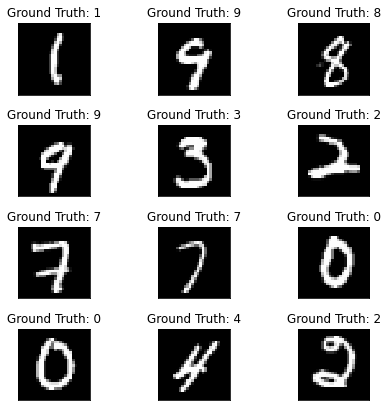

In [147]:
# plotting some sample digits
import matplotlib.pyplot as plt

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure(figsize=(6,6))
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

### Training the VAE model

In [148]:
VAE_model.train()
len_train_dataset = len(train_loader.dataset)

for epoch in range(1, params['epochs']+1):  
  curr_loss = 0.0

  # iterate over all batches
  for X, y in train_loader:
    X = X.to(device)
    decoded_X, mu, logvar = VAE_model(X)

    loss = VAE_loss(decoded_X, X.view(-1, 784), mu, logvar, beta=0.5)
    curr_loss += loss.item()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if epoch % params['log_after'] == 0:
    print(f'====> Epoch: {epoch}, Average loss: {(curr_loss / len_train_dataset):.4f}')

====> Epoch: 5, Average loss: 99.0524
====> Epoch: 10, Average loss: 93.5936
====> Epoch: 15, Average loss: 91.5827
====> Epoch: 20, Average loss: 90.4441
====> Epoch: 25, Average loss: 89.6701
====> Epoch: 30, Average loss: 89.0840
====> Epoch: 35, Average loss: 88.6575
====> Epoch: 40, Average loss: 88.2605
====> Epoch: 45, Average loss: 87.9880
====> Epoch: 50, Average loss: 87.7282


In [149]:
test_loss = 0.0
mu_arr = []
labels_arr = []

# Loss on test dataset
len_test_dataset = len(test_loader.dataset)

with torch.no_grad():
  VAE_model.eval()
  
  # iterate over all batches
  for X, y in test_loader:  
    X = X.to(device)
    decoded_X, mu, logvar = VAE_model(X)

    loss = VAE_loss(decoded_X, X.view(-1, 784), mu, logvar, beta=0.5)
    test_loss += loss.item()

    # For plotting the latent embeddings later
    mu_arr.append(mu.detach())
    labels_arr.append(y.detach())

mu_tensors = torch.cat(mu_arr)
labels_tensor = torch.cat(labels_arr)
print(f'====> Average loss on test data: {(test_loss / len_test_dataset):.4f}')

====> Average loss on test data: 83.4781


### Generate new images

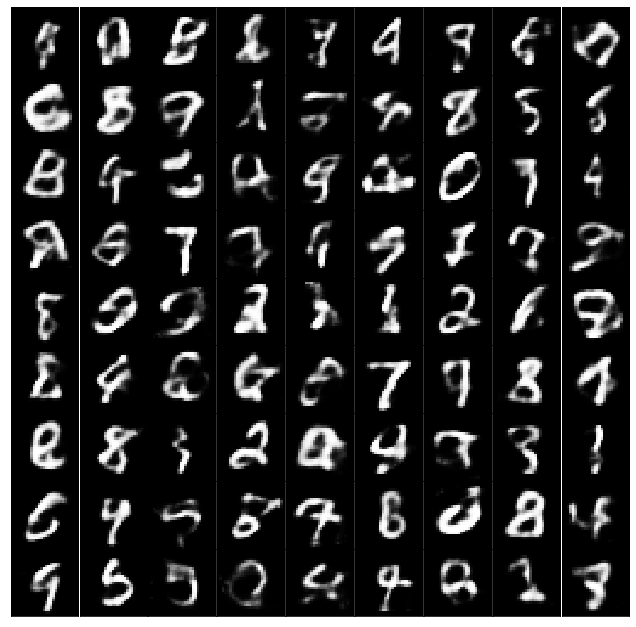

In [150]:
num_images = 81
n_rows = 9
n_cols = num_images // n_rows

# sample latent variables
Z = torch.randn((num_images, params['latent_size'])).to(device)
gen_samples = VAE_model.decoder(Z).data.cpu().view(-1, 28, 28)

fig = plt.figure(figsize=(n_rows,n_cols))
for i in range(num_images):
  plt.subplot(n_rows,n_cols,i+1)
  plt.tight_layout()
  plt.imshow(gen_samples[i], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Visualize the latent space embeddings using T-SNE

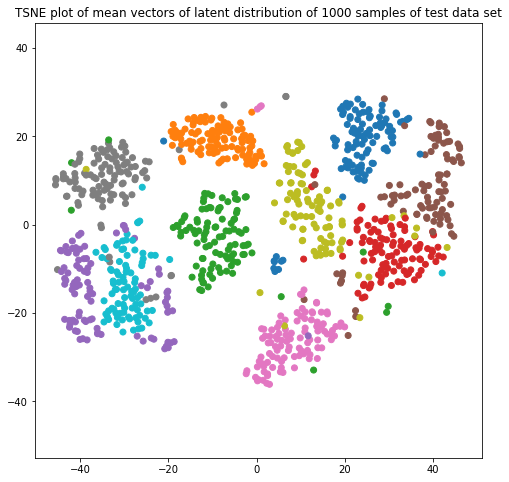

In [151]:
from sklearn.manifold import TSNE

N = params['TSNE_num_samples']
Z_embedded = TSNE(n_components=2).fit_transform(mu_tensors[:N])

fig = plt.figure(figsize=(8,8))
plt.scatter(Z_embedded[:,0], Z_embedded[:,1], c=labels_tensor[:N], cmap='tab10')
plt.grid(False)
plt.title('TSNE plot of mean vectors of latent distribution of 1000 samples of test data set')
plt.axis('equal')
plt.show()